In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from ModelAggregation.PDE_solver_backend import Aggregate,PDESolver

In [75]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [87]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
#u_symbolic=cos(4*pi*x)*cos(pi/2*y)
u_symbolic=(1/(1+exp(-20*(x+0.75)))-1/(1+exp(-20*(x-0.75))))*(1/(1+exp(-20*(y+0.75)))-1/(1+exp(-20*(y-0.75))))
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)
f_symbolic

-(1/(1 + 3269017.37247211*exp(-20*x)) - 1/(1 + 3.05902320501826e-7*exp(-20*x)))*(0.00012236092820073/(1 + 3.05902320501826e-7*exp(-20*y))**2 - 7.48609837507214e-11*exp(-20*y)/(1 + 3.05902320501826e-7*exp(-20*y))**3 - 0.00012236092820073/(3.05902320501826e-7 + exp(-20*y))**2 + 0.000244721856401461*exp(-20*y)/(3.05902320501826e-7 + exp(-20*y))**3)*exp(-20*y) - (1/(1 + 3269017.37247211*exp(-20*y)) - 1/(1 + 3.05902320501826e-7*exp(-20*y)))*(0.00012236092820073/(1 + 3.05902320501826e-7*exp(-20*x))**2 - 7.48609837507214e-11*exp(-20*x)/(1 + 3.05902320501826e-7*exp(-20*x))**3 - 0.00012236092820073/(3.05902320501826e-7 + exp(-20*x))**2 + 0.000244721856401461*exp(-20*x)/(3.05902320501826e-7 + exp(-20*x))**3)*exp(-20*x)

In [88]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.zeros_like(x)#np.power(x,3)
dtau=lambda x:np.zeros_like(x)

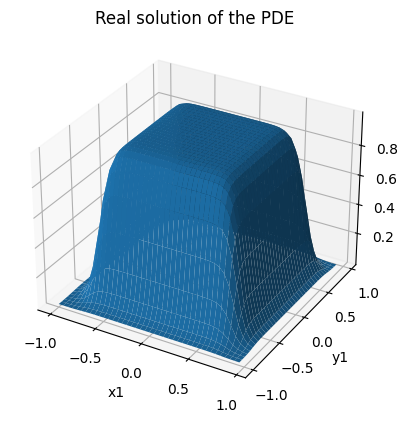

In [89]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

In [90]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

In [91]:
def aggregate_many_models(N_models,N_points_inside,buffer_size,sigma,nugget_aggregate,nugget_model=1e-5):
    models=[]
    for k in range(N_models**2):
        kx=k%N_models
        ky=k//N_models
        range_model=np.array([
            [-1+kx/N_models*2-buffer_size,-1+(kx+1)/N_models*2+buffer_size],
            [-1+ky/N_models*2-buffer_size,-1+(ky+1)/N_models*2+buffer_size]
            ])
        models.append(PDESolver(X_int=make_points_inside(Nd=N_points_inside,range_model=range_model),
                  X_boundary=make_points_boundary(N_points_inside//10),
                  sigma=sigma,
                  name=f'model_{k}'))
        models[-1].fit(f,real_u,tau,dtau,nugget=nugget_model)
    return Aggregate(models,sigma=sigma,nugget=nugget_aggregate)


In [92]:
int_point_number=3500
ext_point_number=500
X_int=make_points_inside(int_point_number)
X_boundary=make_points_boundary(ext_point_number)
X_all=np.concatenate([X_int,X_boundary])

u=PDESolver(X_int=X_int,X_boundary=X_boundary,sigma=0.1)
u.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 2.654e-14: : 2it [00:41, 20.71s/it]


In [94]:
def plot_vectorized_function(f,mesh_size=0.05,zlim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    if zlim is not None:
        ax.axes.set_zlim3d(bottom=zlim[0], top=zlim[1]) 
    return fig

def plot_function(f,zlim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    if zlim is not None:
        ax.axes.set_zlim3d(bottom=zlim[0], top=zlim[1]) 
    return fig

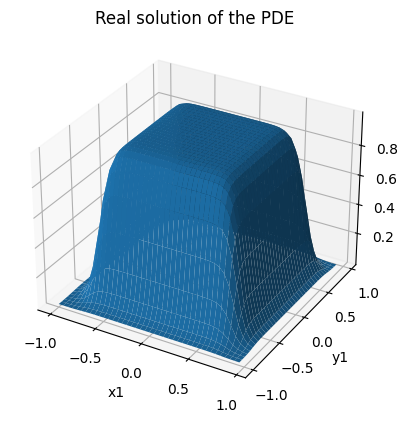

In [95]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

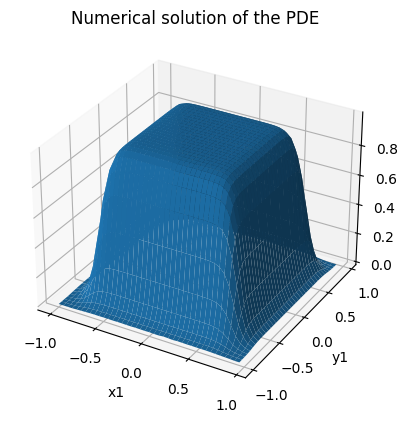

In [96]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

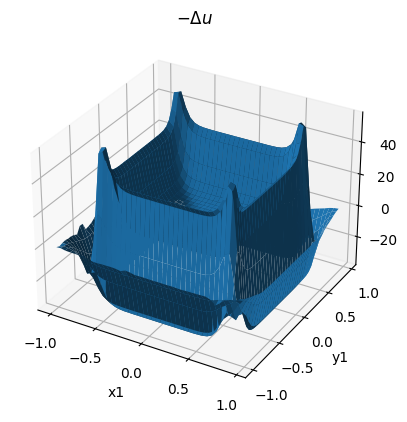

In [73]:
fig=plot_vectorized_function(lambda x:-u.laplacian(x))
#fig=plot_vectorized_function(lambda x:u.laplacian(x))
plt.title('$-\Delta u$')
plt.show()

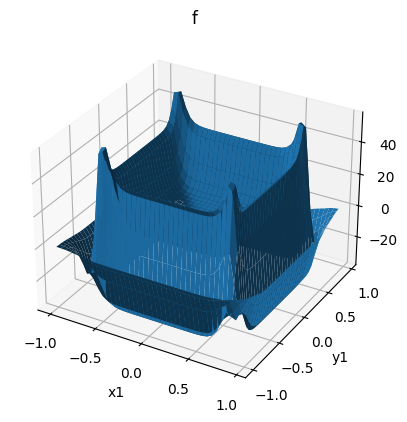

In [71]:
fig=plot_function(f)
plt.title('f')
plt.show()

# With only 2

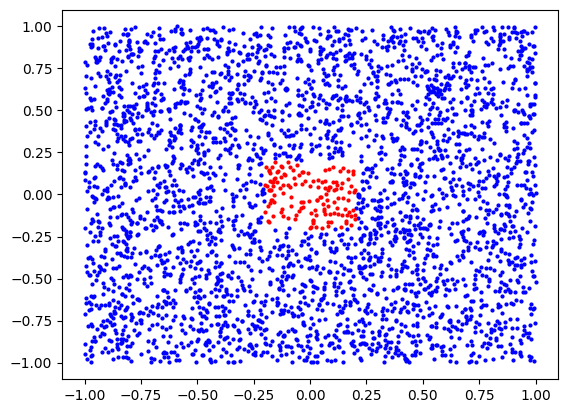

In [111]:
bound=0.2
u_int=PDESolver(
    X_int=make_points_inside(int(int_point_number*(4*bound**2)/4),range_model=np.array([[-bound,bound],[-bound,bound]])),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=0.1)
points_ext=np.concatenate([
    make_points_inside(int(int_point_number*(2*(1-bound))/4),range_model=np.array([[-1,-0.2],[-1,1]])),
    make_points_inside(int(int_point_number*(2*(1-bound))/4),range_model=np.array([[0.2,1],[-1,1]])),
    make_points_inside(int(int_point_number*(0.4*0.8)/4),range_model=np.array([[-0.2,0.2],[-1,-0.2]])),
    make_points_inside(int(int_point_number*(0.4*0.8)/4),range_model=np.array([[-0.2,0.2],[0.2,1]])),
                       
    ])
u_ext=PDESolver(X_int=points_ext,
                X_boundary=make_points_boundary(ext_point_number),
                sigma=0.1)
plt.scatter(points_ext[:,0],points_ext[:,1],c=['b'],s=4)
plt.scatter(u_int.X_int[:,0],u_int.X_int[:,1],c=['r'],s=4)

In [112]:

u_ext.fit(f,real_u,tau,dtau,nugget=1e-5)
u_int.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 4.824e-14: : 2it [00:37, 18.91s/it]
Current residual 1.733e-17: : 2it [00:00, 102.69it/s]


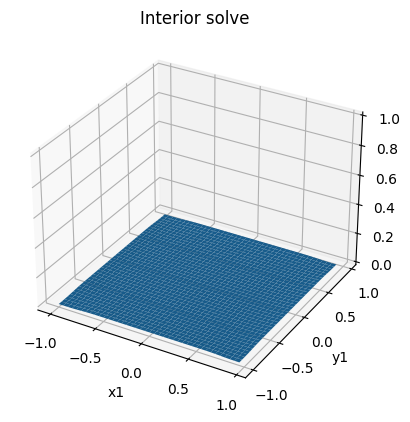

In [114]:
fig=plot_vectorized_function(u_int,zlim=[0,1])
plt.title('Interior solve')
plt.show()

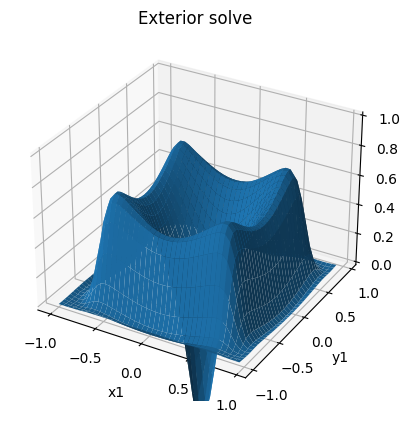

In [115]:
fig=plot_vectorized_function(u_ext,zlim=[0,1])
plt.title('Exterior solve')
plt.show()

# Big aggregate

In [100]:
big_aggregate=aggregate_many_models(N_models=3,N_points_inside=2000,buffer_size=0.0,sigma=0.1,nugget_aggregate=1e-5,nugget_model=1e-5)

Current residual 5.637e-14: : 2it [00:05,  2.83s/it]
Current residual 3.040e-14: : 2it [00:05,  2.93s/it]
Current residual 1.670e-13: : 2it [00:07,  3.56s/it]
Current residual 5.055e-14: : 2it [00:07,  3.86s/it]
Current residual 9.303e-16: : 2it [00:06,  3.07s/it]
Current residual 1.137e-13: : 2it [00:06,  3.14s/it]
Current residual 1.081e-13: : 2it [00:06,  3.09s/it]
Current residual 1.979e-14: : 2it [00:06,  3.06s/it]
Current residual 8.102e-14: : 2it [00:06,  3.08s/it]


M [[ 4.08415284e-03  9.50652033e-05  4.46660354e-05 ...  5.83830898e-05
   4.90291243e-05  6.11330443e-05]
 [-2.64308224e-03  2.80506209e-05  1.25773352e-04 ...  1.20218511e-04
   1.20331354e-04  1.19616270e-04]
 [-5.71191760e-03  3.01724978e-04  3.30236944e-04 ...  3.17517338e-04
   3.18810969e-04  3.18039915e-04]
 ...
 [ 7.30125660e-04  7.26795950e-04  7.31254080e-04 ...  7.54792851e-04
   6.31838149e-04 -3.64289773e-02]
 [ 3.29429187e-04  3.29819210e-04  3.31969276e-04 ...  2.75696539e-04
  -1.68337013e-03 -2.48000330e-02]
 [ 1.76694587e-04  1.78022232e-04  1.80233027e-04 ...  1.81761877e-04
   8.64424889e-04 -1.24775963e-02]]
COV mat [[[1.00000811 0.99991776 0.99998419 ... 0.99037977 0.99748937 0.99651357]
  [0.99991776 0.99993235 0.99992016 ... 0.99069283 0.99764357 0.99668586]
  [0.99998419 0.99992016 0.99999901 ... 0.99046672 0.99752664 0.99657885]
  ...
  [0.99037977 0.99069283 0.99046672 ... 0.99039143 0.99068771 0.99034363]
  [0.99748937 0.99764357 0.99752664 ... 0.99068771 0

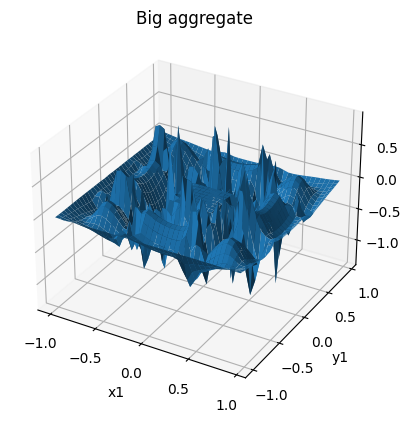

In [101]:
fig=plot_vectorized_function(big_aggregate)
plt.title('Big aggregate')
plt.show()

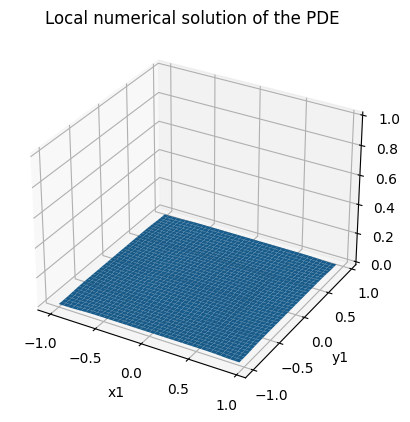

In [102]:
fig=plot_vectorized_function(big_aggregate.models[4],zlim=[0,1])
plt.title('Local numerical solution of the PDE ')
plt.show()

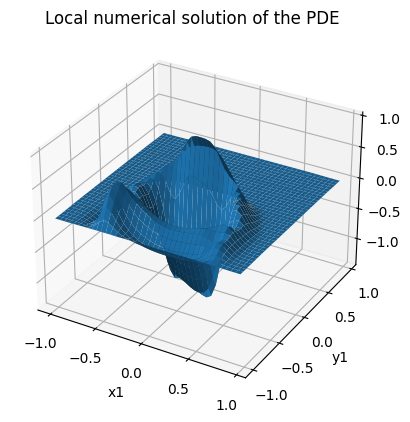

In [104]:
fig=plot_vectorized_function(big_aggregate.models[1])
plt.title('Local numerical solution of the PDE ')
plt.show()